In [1]:
import numpy as np
import torch
%matplotlib inline
from matplotlib import pyplot as plt
import tqdm
import torch.nn.functional as F
import torch.nn as nn
import pickle
import fb_utils as fb
from torch.utils.data import DataLoader
import random
import os

from model import TDFilterbank
from losses import KappaLoss

In [2]:
# set seed
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(0)
np.random.seed(0)

In [3]:
config = {
        "N": 4092,
        "J": 58,
        "T": 1024,
        "sr": 16000,
        "fmin": 64,
        "fmax": 8000,
        "stride": 341,
        "batch_size": 64,
        "epochs": 100,
        "epoch_size": 50,
    }

random_filterbank = fb.random_filterbank(config["N"], config["J"], config["T"], tight=False, support_only=True)
target = 'CQT'
# get current working directory of file
cwd = os.path.abspath('')

with open(cwd+'/targets/'+target+'.pkl', 'rb') as fp:
    target_filterbank_np = pickle.load(fp)["freqz"]
    target_filterbank = torch.from_numpy(target_filterbank_np.T)

# device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cpu'

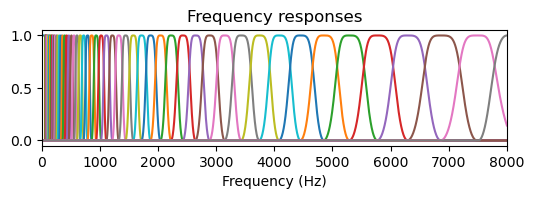

In [4]:
# plot the frequency responses of the target fb

fig = plt.figure(figsize=(6, 1.5))

omega = np.linspace(0, config["sr"], target_filterbank_np.shape[0])
plt.plot(omega, target_filterbank_np/ np.max(target_filterbank_np, axis=0));
plt.title("Frequency responses")
plt.xlim(0, config["sr"]//2+1)
plt.xlabel("Frequency (Hz)");

In [5]:
model_baseline = TDFilterbank(config, random_filterbank)
model_baseline.to(device)
model_kappa = TDFilterbank(config, random_filterbank)
model_kappa.to(device)

TDFilterbank(
  (psi): Conv1d(1, 58, kernel_size=(1024,), stride=(341,), bias=False)
)

In [6]:
# initialize data generator

synth = fb.generate_random_sine(
    config["sr"],
    config["fmin"],
    config["fmax"],
    config["N"],
    config["batch_size"])

In [7]:
loss_baseline = KappaLoss(beta=0)
loss_kappa = KappaLoss(beta=1e-3)

In [8]:
optimizer_baseline = torch.optim.Adam(model_baseline.parameters(), lr=1e-5)
optimizer_kappa = torch.optim.Adam(model_kappa.parameters(), lr=1e-5)

In [9]:
fit_baseline = []
fit_val_baseline = []
fit_kappa = []
fit_val_kappa = []
kappa_baseline = []
kappa_val_baseline = []
kappa_kappa = []
kappa_val_kappa = []

w = model_baseline.psi.weight.detach().numpy()[:,0,:]
w = np.pad(w, ((0,0),(0, config["N"]-config["T"])), constant_values=0)
A,B = fb.frame_bounds_lp(w)
kappa_baseline.append(B/A)
kappa_val_baseline.append(B/A)

w = model_kappa.psi.weight.detach().numpy()[:,0,:]
w = np.pad(w, ((0,0),(0, config["N"]-config["T"])), constant_values=0)
A,B = fb.frame_bounds_lp(w)
kappa_kappa.append(B/A)
kappa_val_kappa.append(B/A)

print(f"Init condition numbers:")
print(f"\tBaseline condition number {kappa_baseline[-1]:.2f}")
print(f"\tKappa condition number {kappa_kappa[-1]:.2f}")

for epoch in range(config["epochs"]):
    running_loss = 0.0
    running_kappa = 0.0

    running_val_loss = 0.0
    running_val_kappa = 0.0

    model_baseline.train()
    model_kappa.train()

    for _ in range(config["epoch_size"]):
        x = next(synth)
        x_out = fb.filterbank_response_fft(x, target_filterbank, config)
        
        x_out_baseline = model_baseline(x)
        base_loss_i, _ = loss_baseline(x_out_baseline, x_out)
        
        x_out_kappa = model_kappa(x)
        w = model_kappa.psi.weight[:,0,:]
        w = F.pad(w,(0,config["N"]-config["T"]), value=0)
        base_loss_kappa_i, loss_kappa_i = loss_kappa(x_out_kappa, x_out, w)

        optimizer_baseline.zero_grad()
        base_loss_i.backward()
        optimizer_baseline.step()

        optimizer_kappa.zero_grad()
        loss_kappa_i.backward()
        optimizer_kappa.step()

        running_loss += base_loss_i.item()
        running_kappa += base_loss_kappa_i.item()
    
    model_baseline.eval()
    model_kappa.eval()
    with torch.no_grad():
        for _ in range(config["epoch_size"]//10):
            x = next(synth)
            x_out = fb.filterbank_response_fft(x, target_filterbank, config)
            
            x_out_baseline = model_baseline(x)
            base_loss_i, _ = loss_baseline(x_out_baseline, x_out)
            
            x_out_kappa = model_kappa(x)
            w = model_kappa.psi.weight[:,0,:]
            w = F.pad(w,(0,config["N"]-config["T"]), value=0)
            base_loss_kappa_i, loss_kappa_i = loss_kappa(x_out_kappa, x_out, w)

            running_val_loss += base_loss_i.item()
            running_val_kappa += base_loss_kappa_i.item()

    w = model_baseline.psi.weight.detach().numpy()[:,0,:]
    w = np.pad(w, ((0,0),(0, config["N"]-config["T"])), constant_values=0)
    A,B = fb.frame_bounds_lp(w)
    kappa_baseline.append(B/A)
    
    w = model_kappa.psi.weight.detach().numpy()[:,0,:]
    w = np.pad(w, ((0,0),(0, config["N"]-config["T"])), constant_values=0)
    A,B = fb.frame_bounds_lp(w)
    kappa_kappa.append(B/A)

    fit_baseline.append(running_loss/config["epoch_size"])
    fit_kappa.append(running_kappa/config["epoch_size"])

    w = model_baseline.psi.weight.detach().numpy()[:,0,:]
    w = np.pad(w, ((0,0),(0, config["N"]-config["T"])), constant_values=0)
    A,B = fb.frame_bounds_lp(w)
    kappa_val_baseline.append(B/A)
    
    w = model_kappa.psi.weight.detach().numpy()[:,0,:]
    w = np.pad(w, ((0,0),(0, config["N"]-config["T"])), constant_values=0)
    A,B = fb.frame_bounds_lp(w)
    kappa_val_kappa.append(B/A)

    fit_val_baseline.append(running_val_loss/(config["epoch_size"]//10))
    fit_val_kappa.append(running_val_kappa/(config["epoch_size"]//10))


    print(f"Epoch {epoch+1}/{config['epochs']}:")
    print(f"\tBaseline Loss: {fit_baseline[-1]:.2f} with condition number {kappa_baseline[-1]:.2f}")
    print(f"\tKappa Loss: {fit_kappa[-1]:.2f} with condition number {kappa_kappa[-1]:.2f}")

    # if fit_kappa[-1] - fit_baseline[-1] > 1e-25:
    #     loss_kappa.beta = loss_kappa.beta/2
    #     print(f"\tDecreasing kappa loss weight to {loss_kappa.beta:.2e}")
    # elif fit_kappa[-1] - fit_baseline[-1] < -1e-25:
    #     loss_kappa.beta = loss_kappa.beta*2
    #     print(f"\tIncreasing kappa loss weight to {loss_kappa.beta:.2e}")

Init condition numbers:
	Baseline condition number 2.42
	Kappa condition number 2.42
Epoch 1/100:
	Baseline Loss: 0.36 with condition number 2.41
	Kappa Loss: 0.36 with condition number 1.72
Epoch 2/100:
	Baseline Loss: 0.32 with condition number 2.74
	Kappa Loss: 0.33 with condition number 1.63
Epoch 3/100:
	Baseline Loss: 0.29 with condition number 3.43
	Kappa Loss: 0.30 with condition number 1.65
Epoch 4/100:
	Baseline Loss: 0.27 with condition number 4.18
	Kappa Loss: 0.28 with condition number 1.70
Epoch 5/100:
	Baseline Loss: 0.25 with condition number 4.85
	Kappa Loss: 0.25 with condition number 1.75
Epoch 6/100:
	Baseline Loss: 0.23 with condition number 5.48
	Kappa Loss: 0.24 with condition number 1.82
Epoch 7/100:
	Baseline Loss: 0.22 with condition number 6.22
	Kappa Loss: 0.23 with condition number 1.90
Epoch 8/100:
	Baseline Loss: 0.21 with condition number 6.95
	Kappa Loss: 0.22 with condition number 1.97
Epoch 9/100:
	Baseline Loss: 0.19 with condition number 7.64
	Kappa

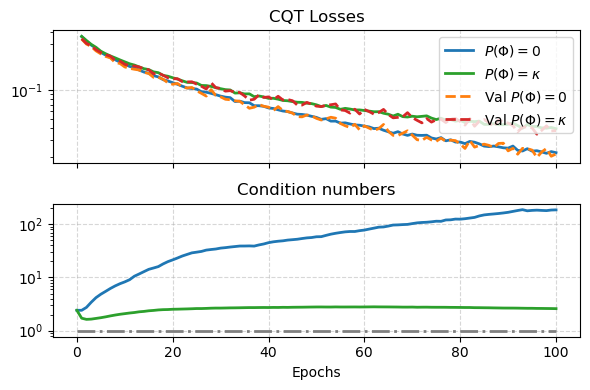

In [10]:
# plot losses and condition numbers over epochs

plt.rcParams['text.usetex'] = False

fig, axes = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
Ts = np.arange(0, config['epochs']+1)

ax = axes[0]
ax.plot(Ts[1:], fit_baseline, 'tab:blue', linewidth=2, label='$P(\Phi)=0$')
ax.plot(Ts[1:], fit_kappa, 'tab:green', linewidth=2, label='$P(\Phi)=\kappa$')
ax.plot(Ts[1:], fit_val_baseline, 'tab:orange', linewidth=2, linestyle='--', label='Val $P(\Phi)=0$')
ax.plot(Ts[1:], fit_val_kappa, 'tab:red', linewidth=2, linestyle='--', label='Val $P(\Phi)=\kappa$')

ax.set_yscale('log')
ax.set_title(target+' Losses')
ax.grid(linestyle='--', alpha=0.5)

ax = axes[1]
ax.plot(Ts, kappa_baseline, 'tab:blue', linewidth=2)
ax.plot(Ts, kappa_kappa, 'tab:green', linewidth=2)
ax.plot(Ts, np.ones(len(Ts)), 'tab:gray', linewidth=2, label='Tightened', linestyle='-.')
ax.set_yscale('log')

ax.set_title('Condition numbers')
ax.set_xlabel('Epochs')
axes[0].legend(loc='upper right')
ax.grid(linestyle='--', alpha=0.5)

plt.tight_layout()

plt.savefig('Fitting_CQT.pdf', bbox_inches='tight')